In [ ]:
!pip install tensorflow
!pip install transformers
!pip install nltk
!pip install langchain
!pip install torch

In [ ]:
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from typing import List, Tuple
import nltk
from nltk.corpus import stopwords

# Ensure NLTK stopwords are downloaded
nltk.download("stopwords")


class CorrectnessScorer:
    def __init__(self, model_name: str = "facebook/bart-large-mnli"):
        """
        Initializes the CorrectnessScorer with a specified NLI model.

        Parameters:
        - model_name (str): The name of the pretrained model to use for NLI tasks. Defaults to "facebook/bart-large-mnli".
        """
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
        self.stop_words = set(stopwords.words("english"))

    def _remove_stopwords(self, text: str) -> str:
        """
        Removes stopwords from the provided text.

        Parameters:
        - text (str): The input text from which stopwords will be removed.

        Returns:
        - str: The text after stopword removal.
        """
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in self.stop_words]
        return " ".join(filtered_words)

    def compute_nli_score(
        self, merged_facts: str, generated_output: str
    ) -> Tuple[float, float, float]:
        """
        Computes the entailment, neutral, and contradiction probabilities using the NLI model.

        Parameters:
        - merged_facts (str): The reference text to be compared against.
        - generated_output (str): The text generated by the model to be evaluated.

        Returns:
        - Tuple[float, float, float]: The probabilities for entailment, neutral, and contradiction.
        """
        try:
            # Clean the input texts by removing stopwords
            merged_facts_clean = self._remove_stopwords(merged_facts)
            generated_output_clean = self._remove_stopwords(generated_output)

            # Tokenize the inputs
            inputs = self.tokenizer(
                merged_facts_clean,
                generated_output_clean,
                return_tensors="tf",
                truncation=True,
                padding=True,
            )
            # Get model outputs
            outputs = self.model(inputs)
            # Apply softmax to get probability scores
            softmax_scores = tf.nn.softmax(outputs.logits, axis=1)[0]

            # Extract individual probabilities
            contradiction_prob = softmax_scores[0].numpy()
            neutral_prob = softmax_scores[1].numpy()
            entailment_prob = softmax_scores[2].numpy()

            return entailment_prob, neutral_prob, contradiction_prob
        except Exception as e:
            print(f"Error during NLI score computation: {e}")
            return 0.0, 0.0, 1.0  # Default to contradiction in case of error

    def custom_pms_function(
        self, entailment_prob: float, neutral_prob: float, contradiction_prob: float
    ) -> float:
        """
        Calculates a Partial Match Score (PMS) using a custom formula.

        Parameters:
        - entailment_prob (float): Probability of entailment.
        - neutral_prob (float): Probability of neutral.
        - contradiction_prob (float): Probability of contradiction.

        Returns:
        - float: The PMS value, adjusted between -0.5 and 1.0.
        """
        # Weighted sum of probabilities
        weighted_sum = (
            0.3 * entailment_prob - 0.4 * contradiction_prob + 0.35 * neutral_prob
        )
        # Apply sigmoid function
        sigmoid_value = 1 / (1 + np.exp(-weighted_sum))
        # Adjust the PMS value
        pms_value = 1.5 * sigmoid_value - 0.5
        return max(-0.5, min(pms_value, 0.5))

    def calculate_correctness_score(
        self, merged_facts: str, generated_output: str
    ) -> Tuple[float, float, float, float]:
        """
        Calculates the overall correctness score using EMS, PMS, and FIP metrics.

        Parameters:
        - merged_facts (str): The reference text containing key facts.
        - generated_output (str): The output generated by the model to be evaluated.

        Returns:
        - Tuple[float, float, float, float]: Averages for EMS, PMS, FIP, and the overall correctness score.
        """
        ems_total, pms_total, fip_total, total_key_facts = 0, 0, 0, 0
        generated_statements = [
            s.strip() for s in generated_output.split(".") if s.strip()
        ]

        for statement in generated_statements:
            # Compute probabilities for each statement
            entailment_prob, neutral_prob, contradiction_prob = self.compute_nli_score(
                merged_facts, statement
            )

            # Update EMS based on entailment probability
            if entailment_prob > 0.5:
                ems_total += 0.5

            # Calculate and accumulate PMS
            pms_value = self.custom_pms_function(
                entailment_prob, neutral_prob, contradiction_prob
            )
            pms_total += pms_value

            # Increment FIP for significant contradictions
            if contradiction_prob > 0.5:
                fip_total += 0.5

            total_key_facts += 1

        # Calculate averages
        if total_key_facts > 0:
            ems_avg = ems_total / total_key_facts * 100
            pms_avg = pms_total / total_key_facts * 100
            fip_avg = fip_total / total_key_facts * 100
            correctness_score = (ems_avg + pms_avg) - fip_avg
            correctness_score = min(correctness_score, 100.0)
        else:
            ems_avg, pms_avg, correctness_score = 0.0, 0.0, 0.0

        return ems_avg, pms_avg, fip_avg, correctness_score


In [6]:
from collections import defaultdict
from typing import Dict, List

class TestingFramework:
    def __init__(self, test_string: str, models: List[str], string_dicts: Dict[str, Dict[str, str]], weights: Dict[str, float]):
        """
        Initializes the TestingFramework with the necessary parameters.

        Parameters:
        - test_string (str): The reference string to compare model outputs against.
        - models (List[str]): A list of model names to be tested.
        - string_dicts (Dict[str, Dict[str, str]]): A dictionary where keys are model names and values 
          are dictionaries mapping test names to model outputs.
        - weights (Dict[str, float]): A dictionary mapping test names to their respective weights 
          for calculating overall grades.
        """
        self.test_string = test_string
        self.models = models
        self.string_dicts = string_dicts
        self.weights = weights
        self.results = defaultdict(dict)
        self.scorer = CorrectnessScorer()  # Assumes CorrectnessScorer is defined elsewhere

    def run_tests(self):
        """
        Runs tests for each model against the reference string.

        Returns:
        - results (defaultdict): A nested dictionary containing evaluation metrics for each model and test.
        """
        for model in self.models:
            for test, output in self.string_dicts[model].items():
                self.results[model][test] = self._evaluate_inference(output, self.test_string)
        return self.results

    def _evaluate_inference(self, model_output: str, reference_string: str):
        """
        Evaluates a model's output against the reference string using the CorrectnessScorer.

        Parameters:
        - model_output (str): The output string generated by the model.
        - reference_string (str): The reference string to compare against.

        Returns:
        - dict: A dictionary containing the EMS, PMS, FIP, and Correctness Score.
        """
        ems_avg, pms_avg, fip_avg, correctness_score = self.scorer.calculate_correctness_score(reference_string, model_output)
        return {
            "EMS": ems_avg,
            "PMS": pms_avg,
            "FIP": fip_avg,
            "Correctness Score": correctness_score
        }

    def detailed_results(self):
        """
        Generates detailed results, including weighted correctness scores for each model and test.

        Returns:
        - detailed (defaultdict): A nested dictionary containing detailed evaluation metrics 
          including weighted correctness scores.
        """
        detailed = defaultdict(dict)
        for model in self.models:
            for test, result in self.results[model].items():
                weighted_correctness_score = result["Correctness Score"] * self.weights.get(test, 1.0)
                detailed[model][test] = {
                    "EMS": result["EMS"],
                    "PMS": result["PMS"],
                    "FIP": result["FIP"],
                    "Correctness Score": result["Correctness Score"],
                    "Weighted Correctness Score": weighted_correctness_score,
                }
        return detailed

    def overall_grades(self):
        """
        Calculates the overall grade for each model based on weighted correctness scores.

        Returns:
        - grades (Dict[str, float]): A dictionary mapping each model to its overall grade.
        """
        grades = {}
        for model, tests in self.detailed_results().items():
            total_weighted_score = sum(
                detail["Weighted Correctness Score"]
                for test, detail in tests.items()
                if test in self.weights
            )
            max_possible_score = sum(self.weights[test] for test in tests if test in self.weights)
            grades[model] = total_weighted_score / max_possible_score if max_possible_score > 0 else 0.0
        return grades

    def calculate_model_scores(self):
        """
        Calculates the total correctness score for each model.

        Returns:
        - Dict[str, float]: A dictionary mapping each model to its total correctness score.
        """
        return {model: sum(detail["Correctness Score"] for detail in self.results[model].values()) for model in self.models}


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_results(detailed_results, models):
    """
    Visualizes the results of the model evaluations, showing Correctness, PMS, EMS, and FIP scores.

    Parameters:
    - detailed_results (dict): Nested dictionary containing detailed scores (Correctness, PMS, EMS, FIP) for each model and test.
    - models (list): List of model names to visualize.

    Returns:
    None: This function only generates and shows the plots.
    """

    # Prepare data for detailed results
    tests = list(detailed_results[models[0]].keys())
    num_models = len(models)
    num_tests = len(tests)

    # Extract scores for each metric across all models and tests
    correctness_scores = {model: [detailed_results[model][test]['Correctness Score'] for test in tests] for model in models}
    pms_scores = {model: [detailed_results[model][test]['PMS'] for test in tests] for model in models}
    ems_scores = {model: [detailed_results[model][test]['EMS'] for test in tests] for model in models}
    fip_scores = {model: [detailed_results[model][test]['FIP'] for test in tests] for model in models}

    # Define a consistent color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    # Create the figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot Correctness Scores
    x = np.arange(num_tests * num_models)
    width = 0.7 / num_models  # Adjust bar width based on the number of models

    for i, model in enumerate(models):
        bar_positions = x[i*num_tests:(i+1)*num_tests] + (i - num_models / 2) * width
        bars = axes[0].bar(
            bar_positions,
            correctness_scores[model],
            width,
            label=model,
            color=colors[i % len(colors)]
        )
        # Add labels to bars
        for j, bar in enumerate(bars):
            height = bar.get_height()
            axes[0].annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                             textcoords="offset points", ha='center', va='bottom')
            # Add the test name and 'Correctness' label below each bar
            axes[0].annotate(f'Test {j+1}\nCorrectness', xy=(bar.get_x() + bar.get_width() / 2, 0), xytext=(0, -20),
                             textcoords="offset points", ha='center', va='top')

    axes[0].set_xlabel('Tests')
    axes[0].set_ylabel('Correctness Scores')
    axes[0].set_title('Correctness Scores by Test')

    # Remove the overall x-tick labels
    axes[0].set_xticks([])
    
    axes[0].legend()
    axes[0].grid(True)

    # Plot PMS, EMS, and FIP Scores
    metric_width = 0.2  # Adjusted width for individual metrics
    gap_width = 0.05  # Adjusted gap width between different metrics to avoid overlap

    for i, model in enumerate(models):
        for j, test in enumerate(tests):
            position_base = x[j + i*num_tests]

            # Plot PMS scores
            bar = axes[1].bar(position_base - (1.5 * metric_width + gap_width), pms_scores[model][j], metric_width, color=colors[i % len(colors)])
            height = bar[0].get_height()
            axes[1].annotate(f'{height:.2f}', xy=(bar[0].get_x() + bar[0].get_width() / 2, height), xytext=(0, 3),
                             textcoords="offset points", ha='center', va='bottom')
            # Add the test and metric name below each bar
            axes[1].annotate(f'Test {j+1}\nPMS', xy=(bar[0].get_x() + bar[0].get_width() / 2, 0), xytext=(0, -20),
                             textcoords="offset points", ha='center', va='top')

            # Plot EMS scores
            bar = axes[1].bar(position_base, ems_scores[model][j], metric_width, color=colors[i % len(colors)])
            height = bar[0].get_height()
            axes[1].annotate(f'{height:.2f}', xy=(bar[0].get_x() + bar[0].get_width() / 2, height), xytext=(0, 3),
                             textcoords="offset points", ha='center', va='bottom')
            # Add the test and metric name below each bar
            axes[1].annotate(f'Test {j+1}\nEMS', xy=(bar[0].get_x() + bar[0].get_width() / 2, 0), xytext=(0, -20),
                             textcoords="offset points", ha='center', va='top')

            # Plot FIP scores
            bar = axes[1].bar(position_base + (1.5 * metric_width + gap_width), fip_scores[model][j], metric_width, color=colors[i % len(colors)])
            height = bar[0].get_height()
            axes[1].annotate(f'{height:.2f}', xy=(bar[0].get_x() + bar[0].get_width() / 2, height), xytext=(0, 3),
                             textcoords="offset points", ha='center', va='bottom')
            # Add the test and metric name below each bar
            axes[1].annotate(f'Test {j+1}\nFIP', xy=(bar[0].get_x() + bar[0].get_width() / 2, 0), xytext=(0, -20),
                             textcoords="offset points", ha='center', va='top')

    axes[1].set_xlabel('Tests')
    axes[1].set_ylabel('Scores')
    axes[1].set_title('PMS, EMS, and FIP by Test')

    # Remove the overall x-tick labels
    axes[1].set_xticks([])

    # Set y-axis limits to avoid clipping
    axes[1].set_ylim(-10, max(max(pms_scores[model]), max(ems_scores[model]), max(fip_scores[model])) + 10)

    axes[1].grid(True)

    # Optimize layout and show the plots
    plt.tight_layout()
    plt.show()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBartForSequenceClassification: ['model.decoder.version', 'model.encoder.version']
- This IS expected if you are initializing TFBartForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBartForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBartForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForSequenceClassification for predictions without further training.


Results:
defaultdict(<class 'dict'>, {'model1': {'test1': {'EMS': 0.0, 'PMS': 37.663629979346446, 'FIP': 0.0, 'Correctness Score': 37.663629979346446}, 'test2': {'EMS': 33.33333333333333, 'PMS': 27.189466670462224, 'FIP': 16.666666666666664, 'Correctness Score': 43.85613333712889}}, 'model2': {'test1': {'EMS': 50.0, 'PMS': 36.18284105478793, 'FIP': 0.0, 'Correctness Score': 86.18284105478793}, 'test2': {'EMS': 0.0, 'PMS': 10.208831410891595, 'FIP': 50.0, 'Correctness Score': -39.79116858910841}}})

Detailed Results:
defaultdict(<class 'dict'>, {'model1': {'test1': {'EMS': 0.0, 'PMS': 37.663629979346446, 'FIP': 0.0, 'Correctness Score': 37.663629979346446, 'Weighted Correctness Score': 37.663629979346446}, 'test2': {'EMS': 33.33333333333333, 'PMS': 27.189466670462224, 'FIP': 16.666666666666664, 'Correctness Score': 43.85613333712889, 'Weighted Correctness Score': 21.928066668564444}}, 'model2': {'test1': {'EMS': 50.0, 'PMS': 36.18284105478793, 'FIP': 0.0, 'Correctness Score': 86.1828410

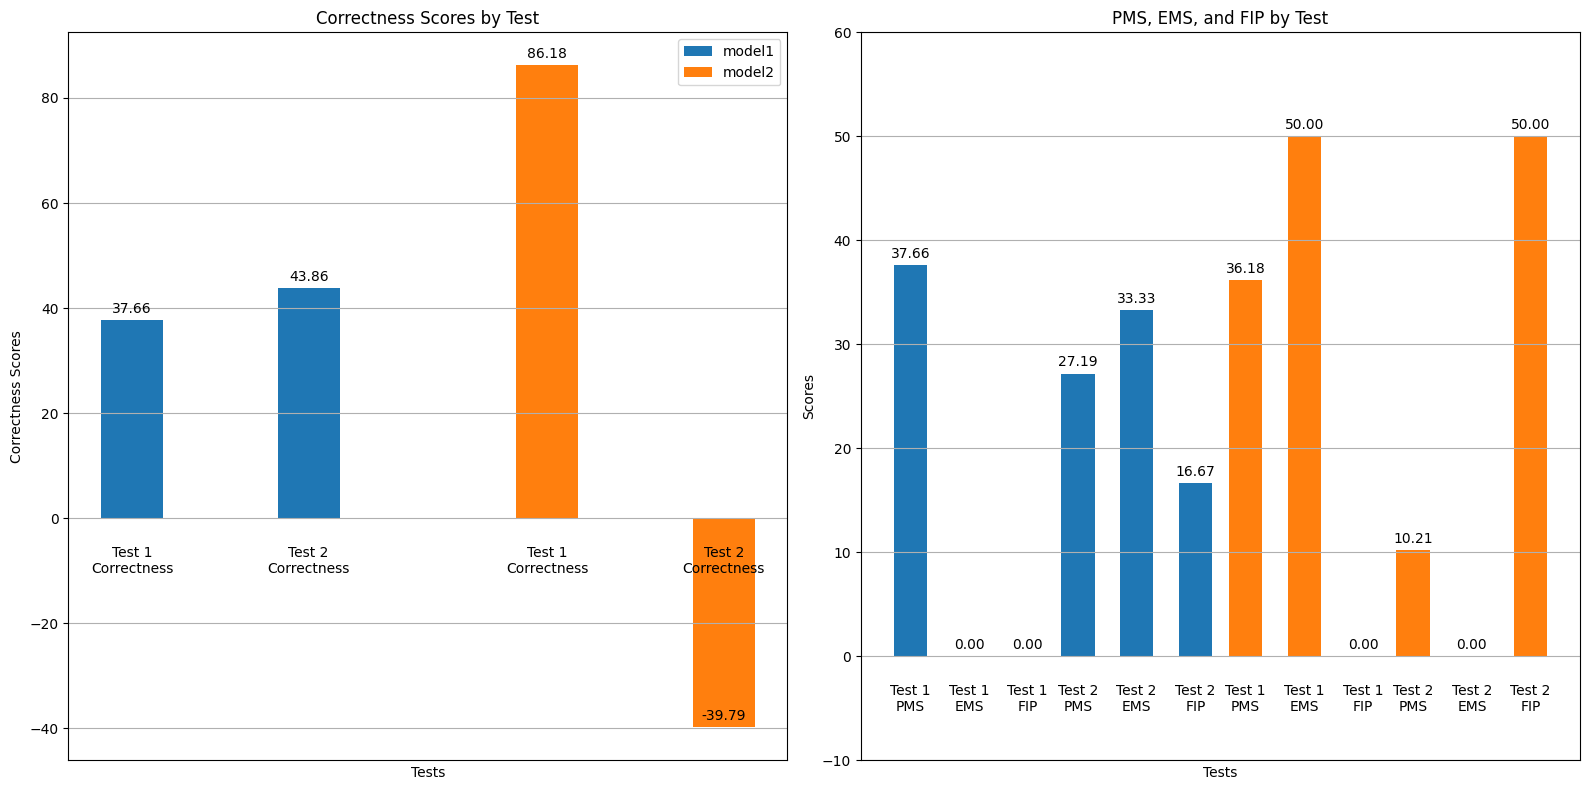

In [14]:
def test_testing_framework():
    """
    Tests the TestingFramework by using a sample test string, model outputs, and weights.

    This function simulates the process of evaluating multiple models against a reference text,
    calculating various metrics, and then visualizing the results.
    """

    # Sample reference string that the models' outputs will be evaluated against
    test_string = (
        "After hearing the news, Sarah couldn’t help but feel a wave of relief wash over her. "
        "She had been worried sick ever since the announcement was made a week ago that her company "
        "might be laying off employees due to financial difficulties. However, the latest update from "
        "the CEO indicated that the company had secured new investments, ensuring job security for everyone."
    )

    # Define the models to be tested
    models = ["model1", "model2"]

    # Example dictionaries containing the outputs of each model for different tests
    string_dicts = {
        "model1": {
            "test1": "Sarah is rich. ",
            "test2": "The company is in financial trouble but now it has new investments.The company layed off Sarah. Sara was worried sick."
        },
        "model2": {
            "test1": "Sarah feels relieved after the company secured new investments.",
            "test2": "Sarah felt an overwhelming sense of dread and fear when she heard the news, knowing that the company had failed to secure any new investments, and layoffs were now inevitable."
        }
    }

    # Weights assigned to each test for the final grading
    weights = {
        "test1": 1.0,
        "test2": 0.5
    }

    # Initialize the TestingFramework with the provided data
    framework = TestingFramework(
        test_string=test_string,
        models=models,
        string_dicts=string_dicts,
        weights=weights
    )

    # Run the tests and calculate results
    results = framework.run_tests()  # Basic results for each model and test
    detailed_results = framework.detailed_results()  # Detailed results with weighted scores
    overall_grades = framework.overall_grades()  # Overall grades for each model
    model_scores = framework.calculate_model_scores()  # Summarized model scores

    # Print results for verification
    print("Results:")
    print(results)

    print("\nDetailed Results:")
    print(detailed_results)

    print("\nOverall Grades:")
    print(overall_grades)

    print("\nModel Scores:")
    print(model_scores)

    # Visualize the results using the previously defined function
    visualize_results(detailed_results, models)

# Run the test case
test_testing_framework()


In [ ]:
!pip install giskard

In [ ]:
import giskard
from giskard import Dataset, Model, TestResult

# Example RAG model function
def rag_model(query):
    # This function should return the response from your RAG model
    # For illustration purposes, we'll return a dummy response
    return "This is a generated response based on retrieved documents."

# Define a simple evaluation function
def evaluate_rag_model():
    # Load or define your dataset (queries and expected answers)
    test_data = [
        {"query": "What is the capital of France?", "expected": "Paris"},
        {"query": "Who wrote '1984'?", "expected": "George Orwell"},
        # Add more test cases as needed
    ]
    
    # Create a Giskard dataset from the test data
    df = pd.DataFrame(test_data)
    dataset = Dataset(df, target="expected")

    # Create a Giskard model
    def prediction_function(data):
        return data["query"].apply(rag_model)

    model = Model(
        prediction_function=prediction_function,
        model_type="text_generation"  # Specify the type of model
    )

    # Run evaluation
    test_results = model.predict(dataset)

    # Compare predictions with expected answers
    accuracy = (test_results.predictions == df["expected"]).mean()

    print(f"Accuracy of the RAG model: {accuracy:.2%}")
    
    # Optionally, return the test results for further analysis
    return test_results

# Run the evaluation
evaluate_rag_model()


In [4]:
from transformers import LlamaTokenizer, LlamaForCausalLM
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
from scipy.spatial.distance import minkowski, mahalanobis
from scipy.stats import entropy
from sklearn.feature_extraction.text import TfidfVectorizer
import torch

class QueryIntentAlignmentScore:
    def __init__(self, query_intent, retrieved_content, generated_content):
        self.query_intent = query_intent
        self.retrieved_content = retrieved_content
        self.generated_content = generated_content
        self.tokenizer = LlamaTokenizer.from_pretrained('meta-llama/Llama-2-70b')
        self.model = LlamaForCausalLM.from_pretrained('meta-llama/Llama-2-70b')
        self.sentiment_analyzer = SentimentIntensityAnalyzer()
        self.vectorizer = TfidfVectorizer()  # For sparse vector representations

    def calculate_rms(self):
        return self._assign_score(self.retrieved_content, self.query_intent)

    def calculate_gas(self):
        return self._assign_score(self.generated_content, self.query_intent)

    def calculate_qias(self):
        rms = self.calculate_rms()
        gas = self.calculate_gas()
        return (rms + gas) / 2

    def _assign_score(self, content, intent):
        return self._evaluate_content(content, intent)

    def _evaluate_content(self, content, intent):
        # Tokenize and vectorize the intent and content
        corpus = [intent, content]
        vectors = self.vectorizer.fit_transform(corpus).toarray()

        intent_vector = vectors[0]
        content_vector = vectors[1]

        # Mahalanobis Jaccard Similarity
        cov_matrix = np.cov(np.stack([intent_vector, content_vector]), rowvar=False)
        mahalanobis_jaccard_score = self._mahalanobis_jaccard(intent_vector, content_vector, cov_matrix)

        # Minkowski Distance (using p=2 for Euclidean)
        minkowski_dist = self._minkowski_distance(intent_vector, content_vector, p=2)

        # KL Divergence
        kl_divergence_score = self._kl_divergence(intent_vector, content_vector)

        # Combine these to form a relevance score
        relevance_score = (mahalanobis_jaccard_score + minkowski_dist + kl_divergence_score) / 3
        return relevance_score

    def _mahalanobis_jaccard(self, u, v, cov_matrix):
        # Calculate Mahalanobis distance
        u_minus_v = u - v
        mahal_dist = mahalanobis(u, v, np.linalg.inv(cov_matrix))

        # Jaccard similarity approximation (binary presence/absence for simplicity)
        u_bin = u > 0
        v_bin = v > 0
        jaccard_sim = np.sum(u_bin & v_bin) / np.sum(u_bin | v_bin)

        # Combine Mahalanobis and Jaccard (weighted)
        similarity = 1 / (1 + mahal_dist) * jaccard_sim
        return similarity

    def _minkowski_distance(self, u, v, p=2):
        return 1 / (1 + minkowski(u, v, p))  # Invert distance to convert to similarity

    def _kl_divergence(self, p, q):
        # Add a small value to avoid log(0)
        p = np.clip(p, 1e-10, 1)
        q = np.clip(q, 1e-10, 1)
        return 1 / (1 + entropy(p, q))  # Invert divergence to convert to similarity

    def _generate_embedding(self, text):
        inputs = self.tokenizer(text, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(**inputs, output_hidden_states=True)
        # Use the last hidden state as the embedding (you could use pooling strategies too)
        embedding = outputs.hidden_states[-1][:, 0, :]
        return embedding.squeeze().numpy()


In [3]:
# Define the test inputs
query_intent = "Explain the benefits of cloud computing."
retrieved_content = "Cloud computing offers scalable resources, cost efficiency, and remote accessibility for businesses."
generated_content = "Using cloud computing, companies can reduce IT costs, improve collaboration, and access data from anywhere."

# Instantiate the QueryIntentAlignmentScore class
qias = QueryIntentAlignmentScore(query_intent, retrieved_content, generated_content)

# Calculate the QIAS
final_qias = qias.calculate_qias()

# Output the result
print(f"Query-Intent Alignment Score (QIAS): {final_qias}")


ImportError: 
LlamaTokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.
